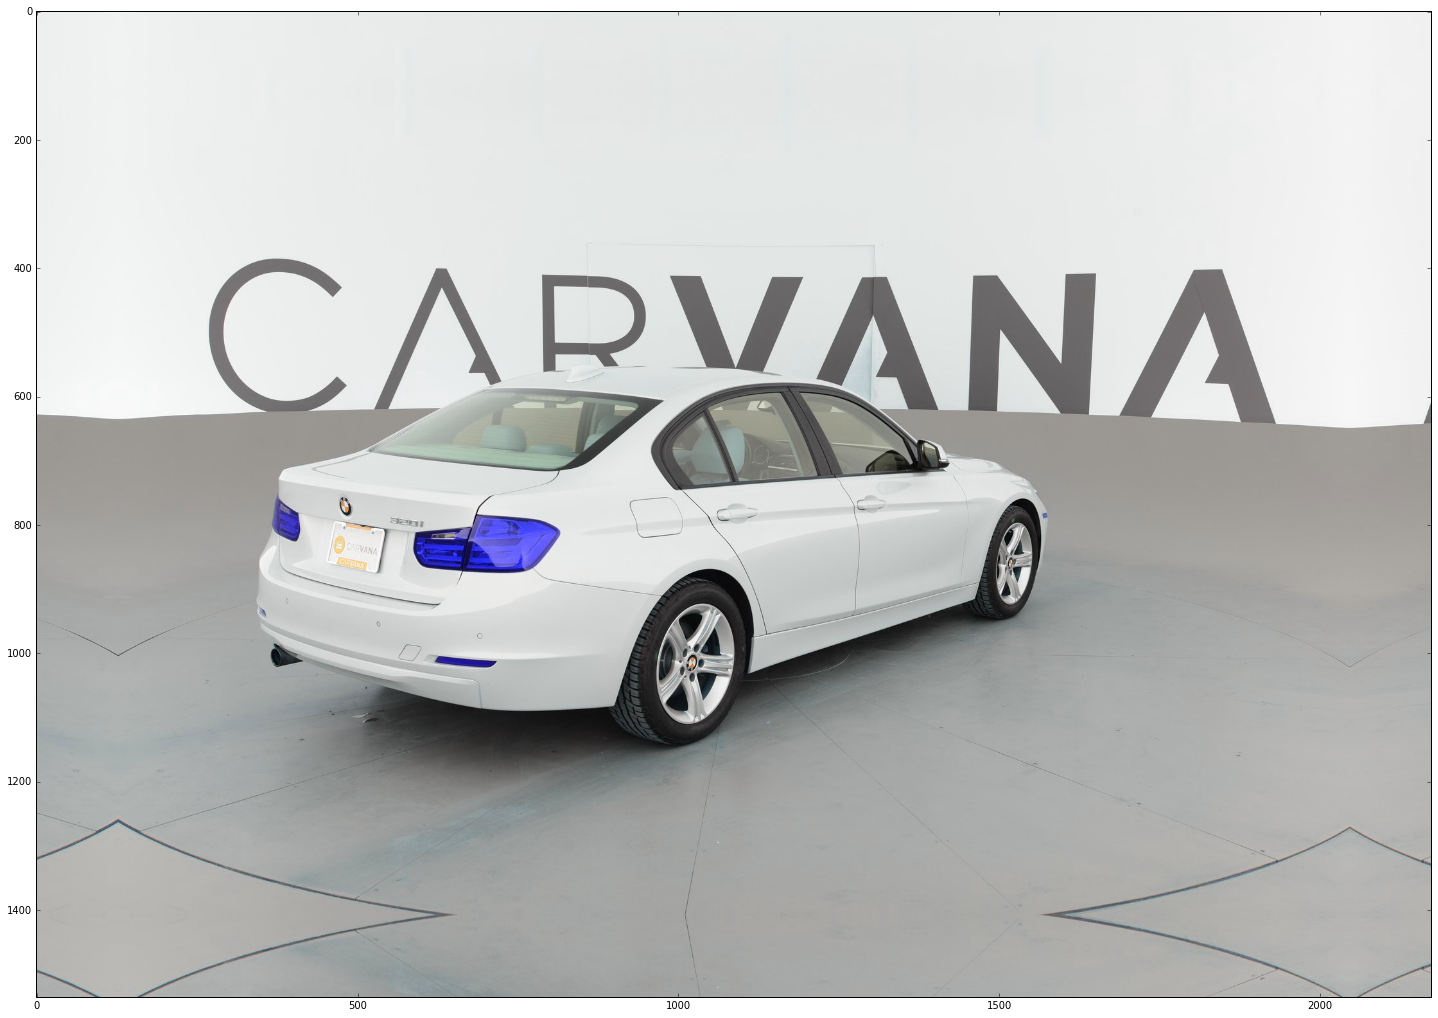

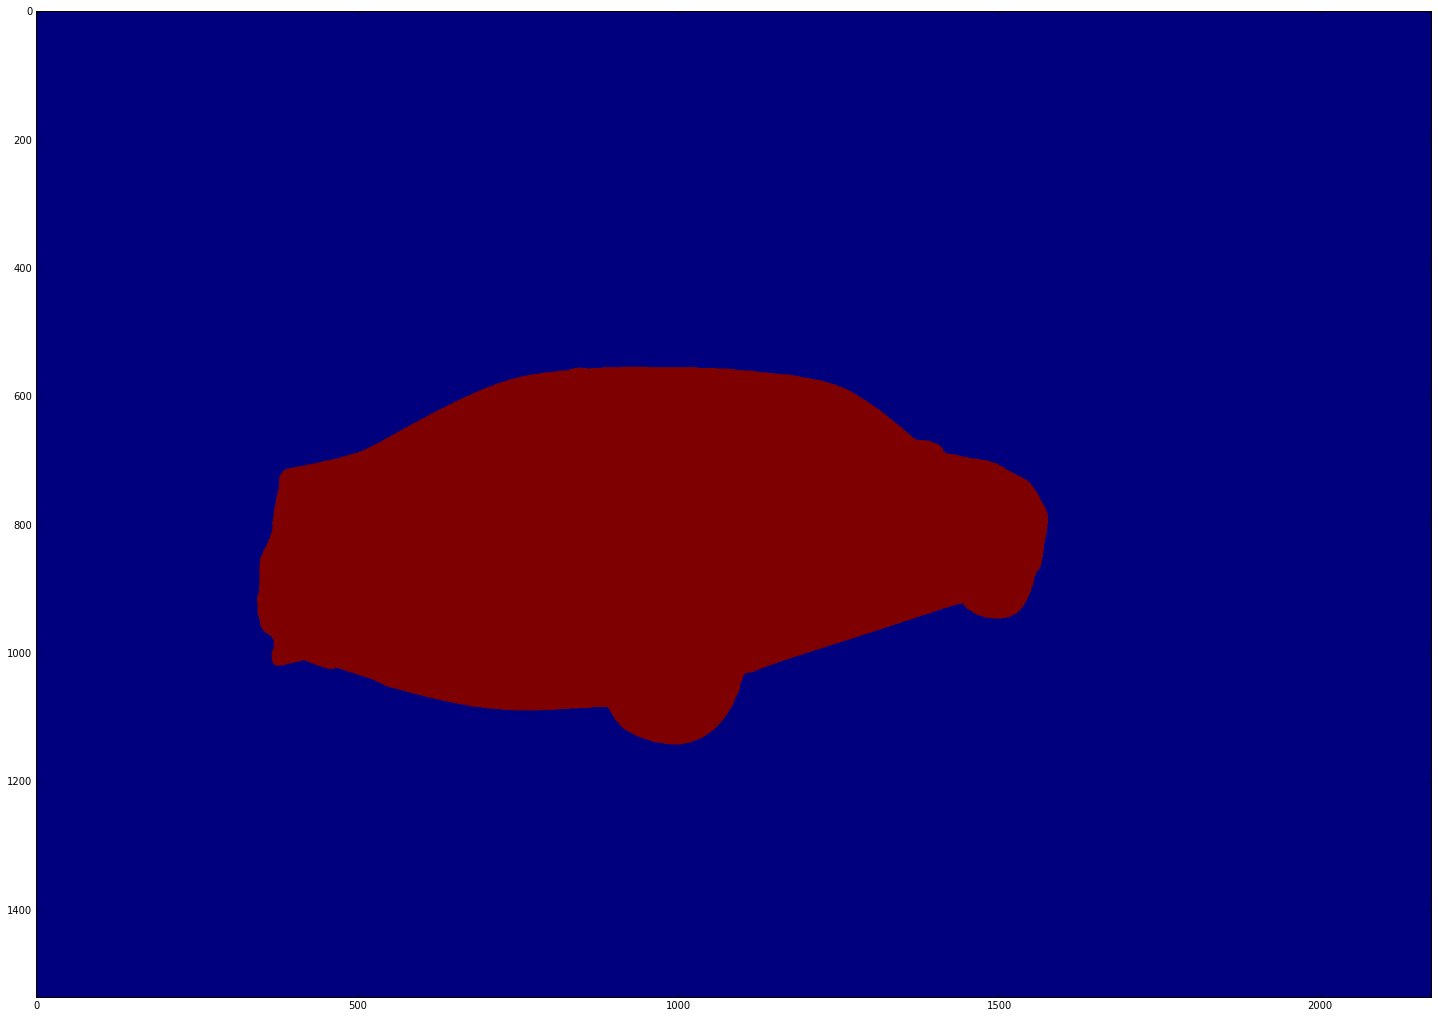

KeyboardInterrupt: 

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import scipy.misc as misc
import os
from u_net import get_unet_128, get_unet_256
import copy

# patch size
N = 256
input_size = 256
batch_size = 32
threshold = 0.5
model = get_unet_256((input_size, input_size, 3))
model.load_weights(filepath='weights/patchesnet_unet256_noaug_sym_pad')

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


#with open("/data/pavel/fcn/DeepLab/unet2/submit/best_weights_skipcon_new_masks.csv") as csv:
with open("/home/antor/didi-ext/carvana/remove_very_small_holes-11.csv") as csv:
    for _ in range(75):
        csv.next()
    for string in csv:
        string = string.strip()

        if 'rle' in string:
            continue

        original_image = cv2.imread('/data/pavel/carv/test_hq/%s' % string.split(',')[0])
        img = original_image
        img = np.pad(img, ((N // 2, N // 2), (N // 2, N // 2), (0, 0)), 'symmetric')
        
        plt.figure(figsize=(25, 25))
        plt.imshow(img)
        plt.show()
        
        original_mask = rle_decode(string.split(',')[1], (1280, 1918))
        original_mask = np.pad(original_mask, ((N // 2, N // 2), (N // 2, N // 2)), 'symmetric')
        
        plt.figure(figsize=(25, 25))
        plt.imshow(original_mask)
        plt.show()
        
        border = np.abs(np.gradient(original_mask)[1]) + np.abs(np.gradient(original_mask)[0])
        border = np.select([border == 0.5, border != 0.5], [1.0, border])
        
        height, width = original_mask.shape

        patches_img = []
        patches_loc = []

        i = 0
        for x, y in zip(np.nonzero(border)[0], np.nonzero(border)[1]):
            if i % 50 == 0 and x - N // 2 >= 0 and y - N // 2 >= 0:
                #cv2.rectangle(img,(y-N//2-1,x-N//2-1),(y+N//2,x+N//2),(255,255,0),1)
                patches_img.append(img[x - N // 2:x + N // 2, y - N // 2:y + N // 2, :])
                patches_loc.append([x - N // 2, x + N // 2, y - N // 2, y + N // 2])
            i = i + 1
            
        patches_img_copy = copy.deepcopy(patches_img)
        
        def test_generator():
            while True:
                for start in range(0, len(patches_img), batch_size):
                    x_batch = []
                    end = min(start + batch_size, len(patches_img))
                    test_batch = copy.deepcopy(patches_img)[start:end]                   
                    for im in test_batch:
                        x_batch.append(im)
                    x_batch = np.array(x_batch, np.float32) / 255
                    yield x_batch
                    
        preds = model.predict_generator(generator=test_generator(),
                                    steps=np.ceil(float(len(patches_img)) / float(batch_size)))
        preds = np.squeeze(preds, axis=3)
        
        weights = np.zeros(original_mask.shape, dtype=np.float32)
        mask = np.zeros(original_mask.shape, dtype=np.float32)
        
        original_mask_patches = np.zeros_like(original_mask)
        for pred, patch, loc in zip(preds, patches_img, patches_loc):
            #if np.median(np.minimum(pred, 1- pred)) > 4e-6:
            #    continue
            mask[loc[0]:loc[1], loc[2]:loc[3]] += pred
            weights[loc[0]:loc[1], loc[2]:loc[3]] += 1.0
            original_mask_patches[loc[0]:loc[1], loc[2]:loc[3]] = original_mask[loc[0]:loc[1], loc[2]:loc[3]]
            #print np.median(np.minimum(pred, 1- pred)), np.min(np.minimum(pred, 1- pred)), np.max(np.minimum(pred, 1- pred))
                        
            #break
        
        mask = mask/weights
        print mask.shape
        plt.figure(figsize=(25, 25))
        plt.imshow(mask)
        plt.show()
        
        # unpad
        mask = mask[N//2:-N//2, N//2:-N//2]
        mask = mask > threshold
        mask = np.select([mask == True, mask == False], [np.array(255, dtype=np.uint8), np.array(0, dtype=np.uint8)])
        

        plt.figure(figsize=(25, 25))
        plt.imshow(mask)
        plt.show()
        
        original_mask_patches = original_mask_patches[N//2:-N//2, N//2:-N//2]
        
        plt.figure(figsize=(25, 25))
        plt.imshow(np.abs(original_mask_patches*255-mask))
        plt.show()
        
        break